In [67]:
#using package
import numpy as np
from numpy import log
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [68]:
#load data
data = pd.read_csv('prices.csv', index_col = 0)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 00:00:00 to 2016-12-30 00:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [69]:
#number of different companies
print('number of different companies: ', len(list(set(data.symbol))))
print(list(set(data.symbol))[:10])

number of different companies:  501
['ISRG', 'MO', 'EVHC', 'PM', 'OKE', 'XEC', 'NKE', 'CNC', 'K', 'AEP']


In [70]:
#describing data
data.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,79.879997,79.889999,79.110001,80.610001,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [71]:
#choose one stock: FB stock
df = data[data.symbol == 'FB'].copy()
print(df)

           symbol        open       close         low        high      volume
date                                                                         
2013-01-02     FB   27.440001   28.000000   27.420000   28.180000  69846400.0
2013-01-03     FB   27.879999   27.770000   27.590000   28.469999  63140600.0
2013-01-04     FB   28.010000   28.760000   27.830000   28.930000  72715400.0
2013-01-07     FB   28.690001   29.420000   28.650000   29.790001  83781800.0
2013-01-08     FB   29.510000   29.059999   28.860001   29.600000  45871300.0
...           ...         ...         ...         ...         ...         ...
2016-12-23     FB  117.000000  117.269997  116.300003  117.559998  10877300.0
2016-12-27     FB  116.959999  118.010002  116.860001  118.680000  12027700.0
2016-12-28     FB  118.190002  116.919998  116.650002  118.250000  11980200.0
2016-12-29     FB  117.000000  116.349998  116.059998  117.529999   9921400.0
2016-12-30     FB  116.599998  115.050003  114.769997  116.83000

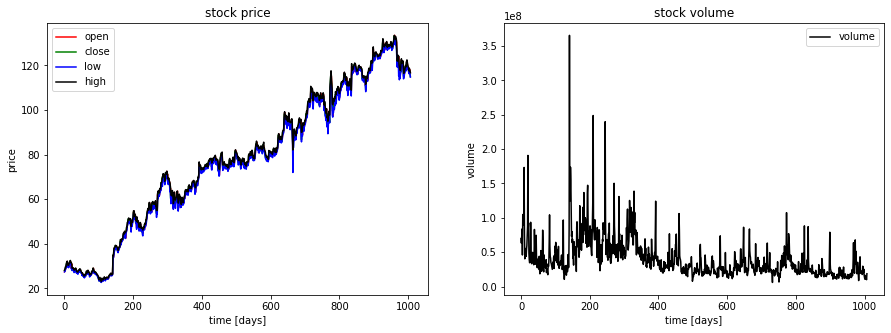

In [72]:
#plot data
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.open.values, color='red', label='open')
plt.plot(df.close.values, color='green', label='close')
plt.plot(df.low.values, color='blue', label='low')
plt.plot(df.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df.volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

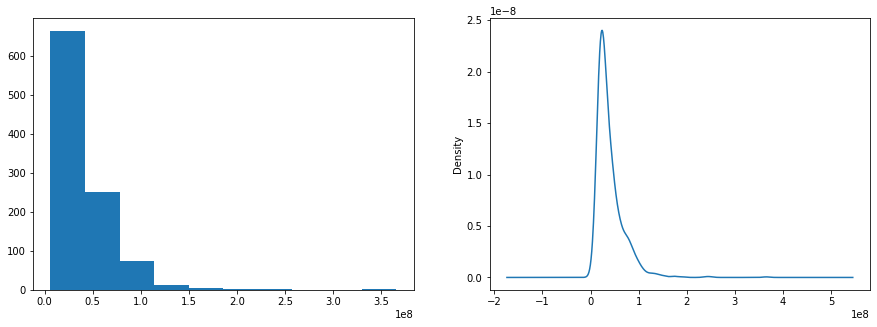

In [73]:
#plot history and density plot
dt = df.volume
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.hist(dt)
plt.subplot(1,2,2);
dt.plot(kind = 'kde')

In [74]:
#describe data
df.describe()

,open,close,low,high,volume
count,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03
mean,77.517718,77.513056,76.597252,78.364911,4.000788e+07
std,31.178965,31.173401,30.959722,31.334932,2.901143e+07
min,22.990000,22.900000,22.670000,23.090000,5.913100e+06
25%,54.930000,55.134999,54.237502,55.830000,2.147998e+07
50%,77.270001,77.555001,76.539997,78.210003,3.086685e+07
75%,105.240001,105.047497,104.005001,106.249998,4.853750e+07
max,133.500000,133.279999,132.220001,133.500000,3.654579e+08


In [75]:
#size of train, validation, test data
nahead = 1
train_percentage = 80
valid_percentage = 10
test_percentage = 10
train_size = int(np.round(train_percentage/100*df.shape[0]))
valid_size = int(np.round(valid_percentage/100*df.shape[0]))
test_size = df.shape[0] - train_size - valid_size

In [76]:
#evaluate model
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y, pred):
    results = pd.DataFrame({'r2_score': r2_score(y, pred),
                           }, index=[0])
    results['mae'] = mean_absolute_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(mean_squared_error(y, pred))
    return results

**Forecast with ARIMA model**

Results of Dickey-Fuller Test:
Test Statistic                   -0.936658
p-value                           0.775661
#Lags Used                        6.000000
Number of Observations Used    1001.000000
Critical Value (1%)              -3.436900
Critical Value (5%)              -2.864432
Critical Value (10%)             -2.568310
dtype: float64


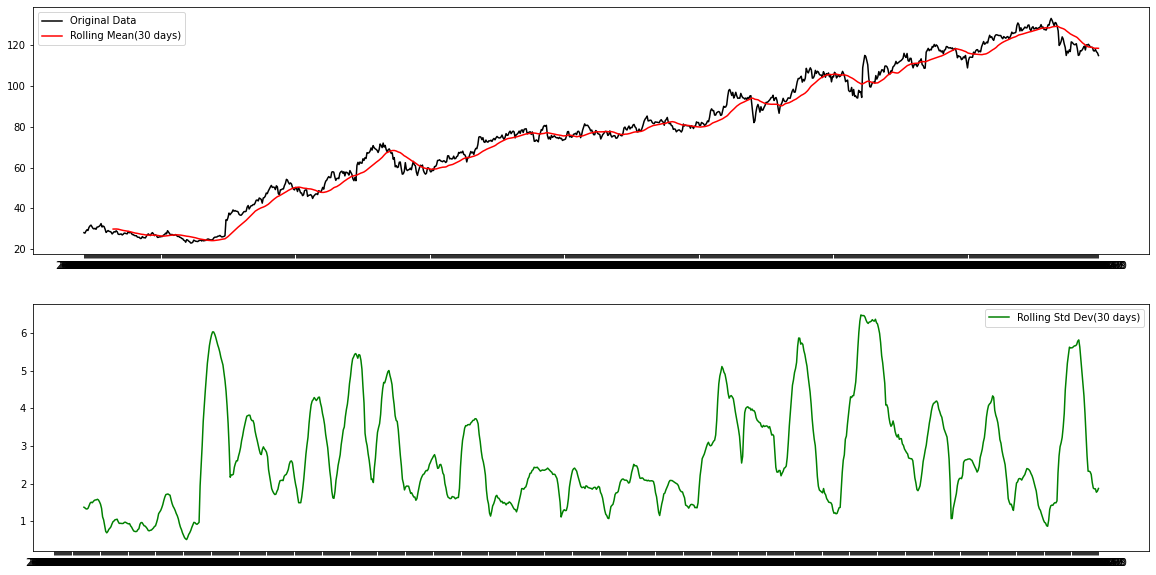

In [77]:
def test_stationarity(timeseries):
  rolmean = timeseries.rolling(30).mean()
  rolstd = timeseries.rolling(30).std()

  #Plot rolling statistics:
  fig = plt.figure(figsize=(20,10))
  plt.subplot(211)
  plt.plot(timeseries, color='black', label='Original Data')
  plt.plot(rolmean, color='red', label='Rolling Mean(30 days)')
  plt.legend()
  plt.subplot(212)
  plt.plot(rolstd, color='green', label='Rolling Std Dev(30 days)')
  plt.legend()

  # Perform Dickey-Fuller test
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  
#test stationary raw data
df_close = pd.Series(df.close)
test_stationarity(df_close)

Results of Dickey-Fuller Test:
Test Statistic                -1.493616e+01
p-value                        1.343643e-27
#Lags Used                     5.000000e+00
Number of Observations Used    1.001000e+03
Critical Value (1%)           -3.436900e+00
Critical Value (5%)           -2.864432e+00
Critical Value (10%)          -2.568310e+00
dtype: float64
805
101
101


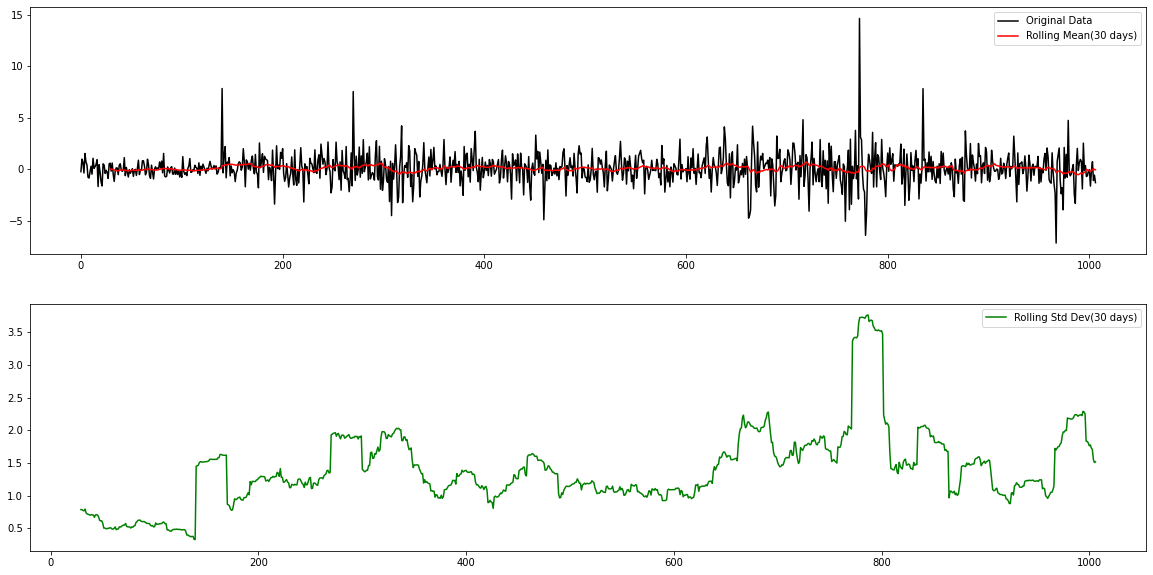

In [78]:
def diffenrence(dataset, interval = 1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

#differencing and split train, validation, test
diff = diffenrence(df_close, 1)
test_stationarity(pd.Series(diff))
numdatadiff = len(df_close) - 1
diff_train = diff[:(numdatadiff - valid_size - test_size)]
diff_valid = diff[(numdatadiff - valid_size - test_size):(numdatadiff - test_size)]
diff_test = diff[(numdatadiff - test_size):]
print(len(diff_train))
print(len(diff_valid))
print(len(diff_test))

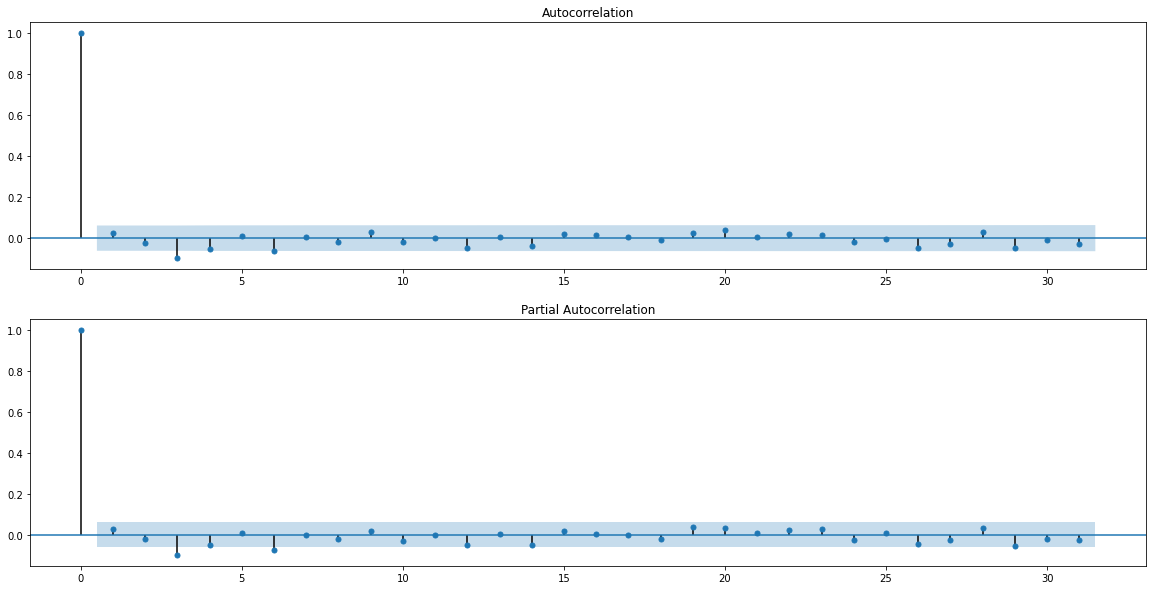

In [79]:
#ACF and PACT plot
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(211)
fig1 = plot_acf(pd.Series(diff), ax=ax1)
ax2 = fig1.add_subplot(212)
fig1 = plot_pacf(pd.Series(diff), ax=ax2)

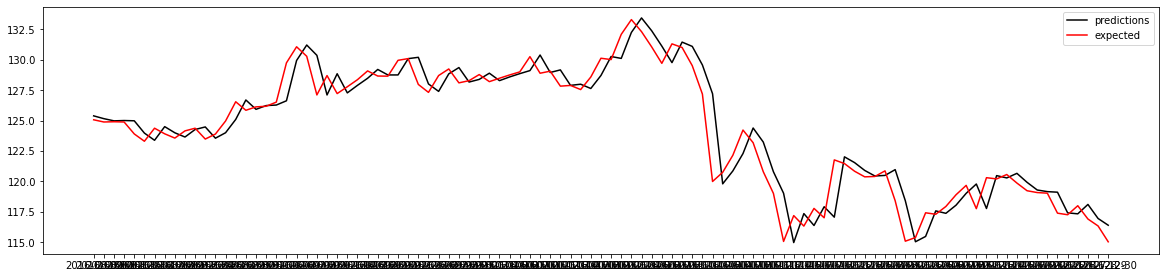

In [80]:
#forecast with ARIMA(1, 0, 0) model
history = [x for x in diff_train]
predictions = []
pred_diff = []
for t in range(len(diff_test)):
  model = ARIMA(history, order = (1, 0, 0))
  model_fit = model.fit(disp = False)
  output = model_fit.forecast()
  yhat = output[0] + df_close[len(df_close) - test_size + t - 1]
  predictions.append(yhat)
  pred_diff.append(output[0])
  history.append(diff_test[t])
fig = plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(predictions, color='black', label='predictions')
plt.plot(df_close[(len(df_close) - test_size):], color='red', label='expected')
plt.legend()

In [81]:
#result of ARIMA model
print(evaluate_forecast(np.array(df_close[(len(df_close) - test_size):]), np.array(predictions)))

   r2_score       mae      mape      rmse
0  0.904847  1.080731  4.556752  1.527332


**Forecast with LSTM model**

In [82]:
#drop symbol and volume column
df.drop(['symbol'],1,inplace=True)
df.drop(['volume'], 1, inplace=True)
df_base = df.copy()

In [83]:
#split train, validation, test data
train = df[:(len(df) - valid_size - test_size)]
valid = df[(len(df) - valid_size - test_size): (len(df) - test_size)]
test = df[(len(df) - test_size):]
print(df.shape)
print(train.shape)
print(valid.shape)
print(test.shape)

(1008, 4)
(806, 4)
(101, 4)
(101, 4)


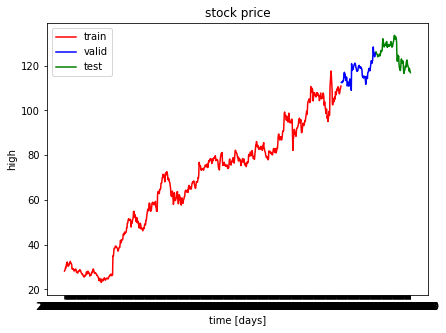

In [84]:
#plot train, validation, test data
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(train.high, color='red', label='train')
plt.plot(valid.high, color='blue', label='valid')
plt.plot(test.high, color='green', label='test')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('high')
plt.legend(loc='best')

In [85]:
def split_sequences(sequence, n_input, n_output = 1):
    X, y= list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_input
        out_end_ix = end_ix + n_output
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        # the sequence[..][0][1] is the value of 2th comlumn, this is close column
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix][0][1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
# train the model
def build_model(train, n_input, numnodes, n_output = 1, n_features = 4):
    # define parameters
    verbose, epochs = 0, 200
    # prepare data
    train_x, train_y = split_sequences(train, n_input, n_output)
    # reshape the data
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(LSTM(numnodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='Adamax', loss='mse')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, verbose=verbose)
    return model
def forecast(model, history, n_input, n_features = 4):
    # retrieve last observations for input data
    input_x = np.array(history[-n_input:])
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), n_features))
    # forecast
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat
    
#build LSTM model and forecast on validation data
n_input, n_output = 10, 1
numnodes = 200
predictions = []
history = []
for i in train.index:
  history.append(train.loc[i].values)
model = build_model(history, n_input, numnodes)
for i in valid.index:
  yhat = forecast(model, history, n_input)
  predictions.append(yhat)
  history.append(valid.loc[i].values)
print(evaluate_forecast(np.array(valid.close), np.array(predictions)))

   r2_score      mae      mape      rmse
0  0.801351  1.37761  3.961335  1.827466


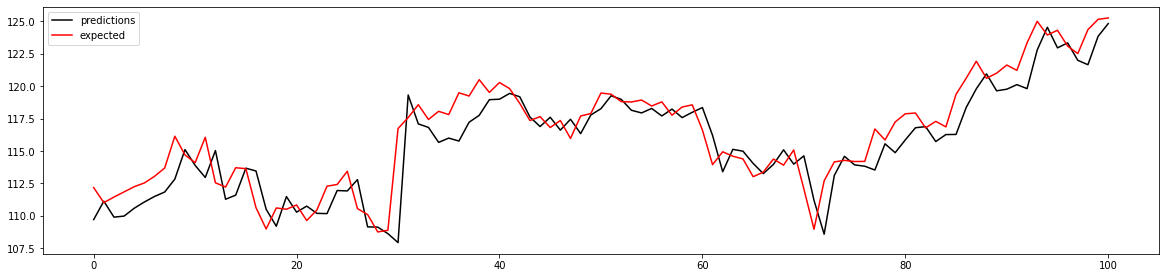

In [86]:
#plot forecast result
fig = plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(predictions, color='black', label='predictions')
plt.plot(valid.close.values, color='red', label='expected')
plt.legend()

In [87]:
#forecast on test data
predictions = []
for i in test.index:
  yhat = forecast(model, history, n_input)
  predictions.append(yhat)
  history.append(test.loc[i].values)
expect = np.array(test.close.values)
predict = np.array(predictions)
print(evaluate_forecast(expect, predict))
#LSTM: 0.902088  1.068501  4.424393  1.549311
#ARIMA: 0.904847  1.080731  4.556752  1.527332

   r2_score       mae      mape      rmse
0  0.909959  1.071786  4.505283  1.485732


In [88]:
# save LSTM model
# model.save('lstm.h5')  # creates a HDF5 file 'lstm.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one

In [89]:
#load and forecast by saved model
model = load_model('lstm.h5')
predictions = []
history = []
for i in train.index:
  history.append(train.loc[i].values)
for i in valid.index:
  history.append(valid.loc[i].values)
for i in test.index:
  yhat = forecast(model, history, n_input)
  predictions.append(yhat)
  history.append(test.loc[i].values)
expect = np.array(test.close.values)
predict = np.array(predictions)
print(evaluate_forecast(expect, predict))

   r2_score       mae      mape      rmse
0  0.910326  1.033753  4.490771  1.482702


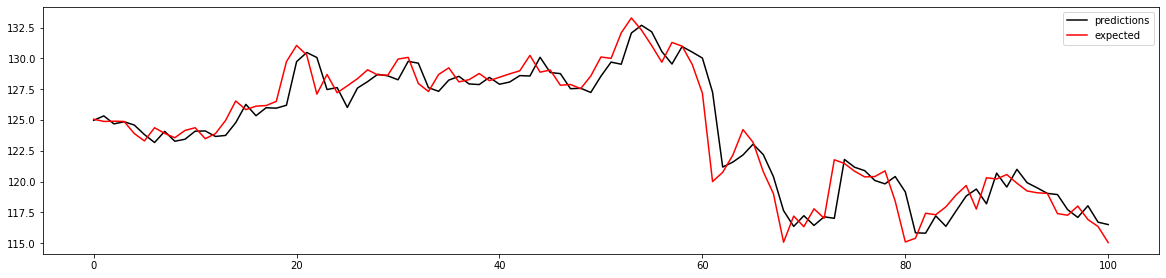

In [90]:
#plot forecast
fig = plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(predict, color='black', label='predictions')
plt.plot(expect, color='red', label='expected')
plt.legend()

In [91]:
def run(numnodes, epochs):
  def split_sequences(sequence, n_input, n_output = 1):
      X, y= list(), list()
      for i in range(len(sequence)):
          # find the end of this pattern
          end_ix = i + n_input
          out_end_ix = end_ix + n_output
          # check if we are beyond the sequence
          if out_end_ix > len(sequence):
              break
          # gather input and output parts of the pattern
          # the sequence[..][0][1] is the value of 2th comlumn, this is close column
          seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix][0][1]
          X.append(seq_x)
          y.append(seq_y)
      return np.array(X), np.array(y)
  # train the model
  def build_model(train, n_input, numnodes, n_output = 1, n_features = 4):
      # define parameters
      verbose = 0
      # prepare data
      train_x, train_y = split_sequences(train, n_input, n_output)
      # reshape the data
      train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
      # define model
      model = Sequential()
      model.add(LSTM(numnodes, activation='relu', input_shape=(n_input, n_features)))
      model.add(Dense(n_output))
      model.compile(optimizer='Adamax', loss='mse')
      # fit network
      model.fit(train_x, train_y, epochs=epochs, verbose=verbose)
      return model
  def forecast(model, history, n_input, n_features = 4):
      # retrieve last observations for input data
      input_x = np.array(history[-n_input:])
      # reshape into [1, n_input, 1]
      input_x = input_x.reshape((1, len(input_x), n_features))
      # forecast
      yhat = model.predict(input_x, verbose=0)
      # we only want the vector forecast
      yhat = yhat[0]
      return yhat
  rs = []
  rs.append(numnodes)
  rs.append(epochs)
  n_input, n_output = 20, 1
  predictions = []
  history = []
  for i in train.index:
    history.append(train.loc[i].values)
  model = build_model(history, n_input, numnodes)
  for i in valid.index:
    yhat = forecast(model, history, n_input)
    predictions.append(yhat)
    history.append(valid.loc[i].values)
  evaluate = evaluate_forecast(np.array(valid.close), np.array(predictions))
  for j in range(4):
    rs.append(evaluate.values[0][j])
  predictions = []
  for i in test.index:
    yhat = forecast(model, history, n_input)
    predictions.append(yhat)
    history.append(test.loc[i].values)
  evaluate = evaluate_forecast(np.array(test.close.values), np.array(predictions))
  for j in range(4):
    rs.append(evaluate.values[0][j])
  return rs

#run for implement the structure of LSTM model
result = []
nodes = [50, 100, 150, 200]
epoches = [50, 100, 150, 200]
# for node in nodes:
#   for epoch in epoches:
#     for size in sizes:
#       for i in range(3):
#         result.append(run(node, epoch, size))
# result = DataFrame(result)
# print(result)
# result.to_csv('runs.csv')

In [92]:
def split_sequences(sequence, n_input, n_output = 5):
    X, y= list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_input
        out_end_ix = end_ix + n_output
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        # the sequence[..][0][1] is the value of 2th comlumn, this is close column
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix][0][1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
# train the model
def build_model(train, n_input, numnodes, n_output = 5, n_features = 4):
    # define parameters
    verbose, epochs, batch_size = 0, 200, 20
    # prepare data
    train_x, train_y = split_sequences(train, n_input, n_output)
    # reshape the data
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(LSTM(numnodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='Adamax', loss='mse')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, verbose=verbose)
    return model
def forecast(model, history, n_input, n_features = 4):
    # retrieve last observations for input data
    input_x = np.array(history[-n_input:])
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), n_features))
    # forecast
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

#example in using LSTM for real problems
symbol = 'AMZN'
df = data[data.symbol == symbol].copy()
df.drop(['symbol'],1,inplace=True)
df.drop(['volume'], 1, inplace=True)
n_input, n_output = 5, 5
numnodes = 200
predictions = []
history = []
for i in df.index:
  history.append(df.loc[i].values)
model = build_model(history, n_input, numnodes)
input = [[3455.00,	3469.865,	3338.60,	3389.79], [3460.00,	3492.70,	3423.75,	3437.36],
      [3545.00,	3559.88,	3441.60,	3443.72], [3563.50,	3585.77,	3492.01,	3507.07],
      [3547.644,	3596.00,	3531.50,	3561.57]]
input = np.array(input)
input = input.reshape((1, len(input), 4))
# forecast
yhat = model.predict(input, verbose=0)
# we only want the vector forecast
yhat = yhat[0]
print(yhat)

1762
[3589.9124 3573.34   3597.179  3564.2903 3576.2532]
